In [3]:
#Basic libraries
import urllib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import datetime as dt
from matplotlib.ticker import MaxNLocator
import PIL
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

from sklearn import set_config; set_config(display='diagram')

In [4]:
#Load Data
full_df = pd.read_csv('../road_to_qatar_2022/data/fulldataset.csv')
full_df

,date,home_team,away_team,home_score,away_score,win_conditions,home_team_rank,home_team_points,home_team_previous_points,away_team_rank,away_team_points,away_team_previous_points
0,1930-07-13,France,Mexico,4.0,1.0,,4,1759.78,1764.85,13,1644.89,1649.57
1,1930-07-13,USA,Belgium,3.0,0.0,,16,1627.48,1635.01,2,1816.71,1821.92
2,1930-07-14,Yugoslavia,Brazil,2.0,1.0,,6,64.00,64.00,1,1841.30,1837.56
3,1930-07-14,Romania,Peru,3.0,1.0,,53,1434.68,1427.84,23,1561.01,1562.24
4,1930-07-15,Argentina,France,1.0,0.0,,3,1773.88,1770.65,4,1759.78,1764.85
...,...,...,...,...,...,...,...,...,...,...,...,...
1026,2022-02-05,Cameroon,Burkina Faso,3.0,3.0,Cameroon,43,1471.44,1484.95,54,1432.25,1425.64
1027,2022-02-06,Senegal,Egypt,0.0,0.0,Senegal,18,1584.38,1584.59,39,1486.44,1482.63
1028,2022-03-29,Senegal,Egypt,1.0,0.0,Senegal,18,1584.38,1584.59,39,1486.44,1482.63
1029,2022-06-13,Australia,Peru,0.0,0.0,Australia,38,1488.72,1483.73,23,1561.01,1562.24


In [5]:
#ADD winner column on dataset 
winner = []
for i in range (len(full_df['home_team'])):
    if full_df ['home_score'][i] > full_df['away_score'][i]:
        winner.append('win')
    elif full_df['home_score'][i] < full_df ['away_score'][i]:
        winner.append('lose')
    else:
        winner.append('Draw')
full_df['home_team_result'] = winner

In [6]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'win_conditions', 'home_team_rank', 'home_team_points',
       'home_team_previous_points', 'away_team_rank', 'away_team_points',
       'away_team_previous_points', 'home_team_result'],
      dtype='object')

# Small Analysis

In [8]:
fifa_rank = full_df[['date','home_team','away_team','home_team_rank', 'away_team_rank']]
home = fifa_rank[['date','home_team','home_team_rank']].rename(columns={"home_team":"team","home_team_rank":"rank"})
away = fifa_rank[['date','away_team','away_team_rank']].rename(columns={"away_team":"team","away_team_rank":"rank"})
fifa_rank = pd.concat([home,away])
#Select each country latest match
fifa_rank = fifa_rank.sort_values(['team','date'],ascending=[True,False])
fifa_rank_top10 = fifa_rank.groupby('team').first().sort_values('rank',ascending=True)[0:11].reset_index()
fifa_rank_top10 = fifa_rank_top10[fifa_rank_top10.team != 'Yugoslavia']#remove this team as his rank is 6, it's unrealistic

In [9]:
fifa_rank_top10 = fifa_rank_top10.drop(['date'],axis=1)

In [10]:
fifa_rank_top10

,team,rank
0,Brazil,1
1,Belgium,2
2,Argentina,3
3,France,4
4,England,5
6,Italy,6
7,Spain,7
8,Netherlands,8
9,Portugal,9
10,Denmark,10


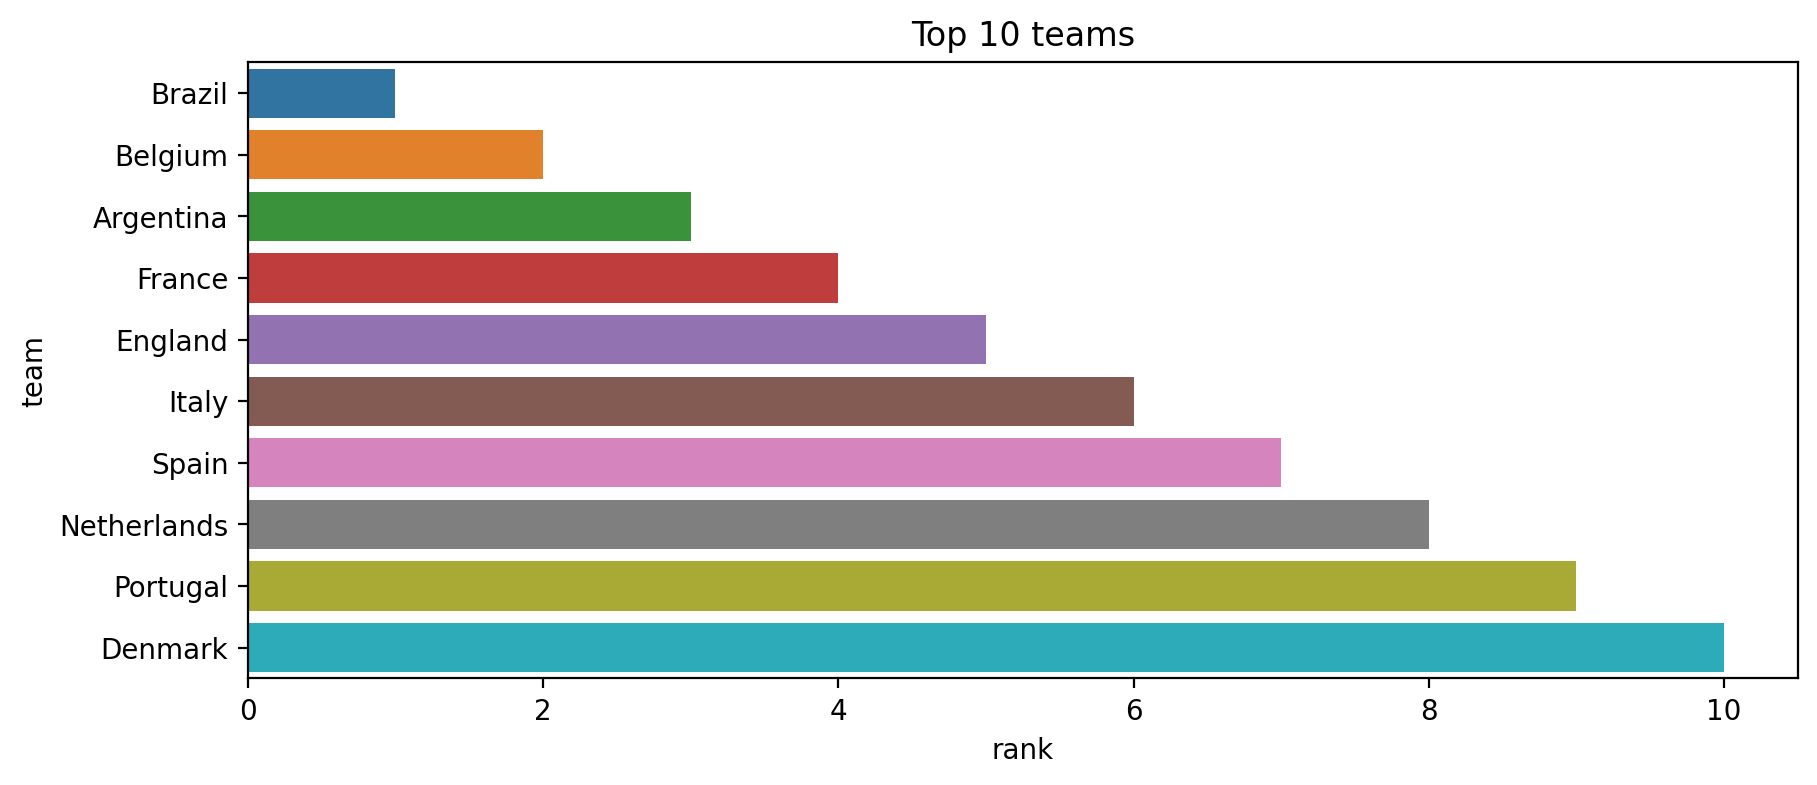

In [11]:
plt.figure(figsize=(10,4),dpi=200)
sns.barplot(data=fifa_rank_top10,y='team',x='rank')
plt.title("Top 10 teams");

In [12]:
#function calculating average win
def home_percentage(team):
    score = len(full_df[(full_df['home_team'] == team) & (full_df['home_team_result'] == "win")]) / len(full_df[full_df['home_team'] == team]) * 100
    return round(score)
def away_percentage(team):
    score = len(full_df[(full_df['away_team'] == team) & (full_df['home_team_result'] == "lose")]) / len(full_df[full_df['away_team'] == team]) * 100
    return round(score)

In [13]:
#add column average win
fifa_rank_top10['Home_win_Per'] = np.vectorize(home_percentage)(fifa_rank_top10['team'])
fifa_rank_top10['Away_win_Per'] = np.vectorize(away_percentage)(fifa_rank_top10['team'])
fifa_rank_top10['Average_win_Per'] = round((fifa_rank_top10['Home_win_Per'] + fifa_rank_top10['Away_win_Per'])/2)
fifa_rank_win = fifa_rank_top10.sort_values('Average_win_Per',ascending=False)
fifa_rank_win

,team,rank,Home_win_Per,Away_win_Per,Average_win_Per
0,Brazil,1,67,39,53.0
8,Netherlands,8,53,42,48.0
6,Italy,6,66,22,44.0
7,Spain,7,50,37,44.0
3,France,4,54,31,42.0
2,Argentina,3,67,9,38.0
1,Belgium,2,58,16,37.0
9,Portugal,9,63,9,36.0
10,Denmark,10,33,38,36.0
4,England,5,56,13,34.0


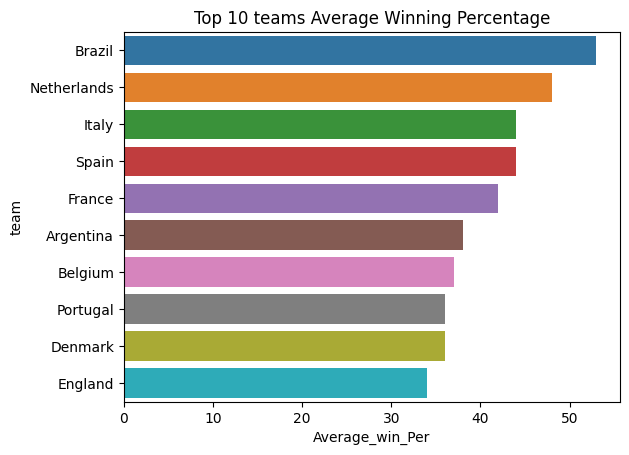

In [14]:
#data viz for top 10 teams
sns.barplot(data=fifa_rank_win,x='Average_win_Per',y='team')
plt.title("Top 10 teams Average Winning Percentage");

In [15]:
full_df.tail()

,date,home_team,away_team,home_score,away_score,win_conditions,home_team_rank,home_team_points,home_team_previous_points,away_team_rank,away_team_points,away_team_previous_points,home_team_result
1026,2022-02-05,Cameroon,Burkina Faso,3.0,3.0,Cameroon,43,1471.44,1484.95,54,1432.25,1425.64,Draw
1027,2022-02-06,Senegal,Egypt,0.0,0.0,Senegal,18,1584.38,1584.59,39,1486.44,1482.63,Draw
1028,2022-03-29,Senegal,Egypt,1.0,0.0,Senegal,18,1584.38,1584.59,39,1486.44,1482.63,win
1029,2022-06-13,Australia,Peru,0.0,0.0,Australia,38,1488.72,1483.73,23,1561.01,1562.24,Draw
1030,2022-06-14,Chile,Ghana,0.0,0.0,Ghana,29,1509.61,1514.86,61,1393.00,1393.47,Draw


In [16]:
#Filter the teams participating in World cup 22
list_2022 = ['Qatar', 'Germany', 'Denmark', 'Brazil', 'France', 'Belgium', 'Croatia', 'Spain', 'Serbia', 'England', 'Switzerland', 'Netherlands', 'Argentina', 'IR Iran', 'Korea Republic', 'Japan', 'Saudi Arabia', 'Ecuador', 'Uruguay', 'Canada', 'Ghana', 'Senegal', 'Portugal', 'Poland', 'Tunisia', 'Morocco', 'Cameroon', 'USA', 'Mexico', 'Wales', 'Australia', 'Costa Rica']
final_df = full_df[(full_df["home_team"].apply(lambda x: x in list_2022)) | (full_df["away_team"].apply(lambda x: x in list_2022))]


In [17]:
#filter latest ranking 
rank = final_df[['date','home_team','away_team','home_team_rank', 'away_team_rank']]
home = rank[['date','home_team','home_team_rank']].rename(columns={"home_team":"team","home_team_rank":"rank"})
away = rank[['date','away_team','away_team_rank']].rename(columns={"away_team":"team","away_team_rank":"rank"})
rank = pd.concat([home,away])
#Select each country latest match
rank = rank.sort_values(['team','date'],ascending=[True,False])
rank_top10 = rank.groupby('team').first().sort_values('rank',ascending=True).reset_index()
rank_top10 = rank_top10[(rank_top10["team"].apply(lambda x: x in list_2022))][0:10]
rank_top10.drop(['date'],axis=1)

,team,rank
0,Brazil,1
1,Belgium,2
2,Argentina,3
3,France,4
4,England,5
7,Spain,7
8,Netherlands,8
9,Portugal,9
10,Denmark,10
11,Germany,11


In [18]:
#updated average win
rank_top10['Home_win_Per'] = np.vectorize(home_percentage)(rank_top10['team'])
rank_top10['Away_win_Per'] = np.vectorize(away_percentage)(rank_top10['team'])
rank_top10['Average_win_Per'] = round((rank_top10['Home_win_Per'] + rank_top10['Away_win_Per'])/2)
rank_top10_Win = rank_top10.sort_values('Average_win_Per',ascending=False)
rank_top10_Win


,team,date,rank,Home_win_Per,Away_win_Per,Average_win_Per
11,Germany,2016-07-02,11,67,49,58.0
0,Brazil,2019-06-27,1,67,39,53.0
8,Netherlands,2014-07-12,8,53,42,48.0
7,Spain,2021-07-06,7,50,37,44.0
3,France,2021-06-28,4,54,31,42.0
2,Argentina,2021-07-06,3,67,9,38.0
1,Belgium,2014-07-05,2,58,16,37.0
9,Portugal,2017-06-28,9,63,9,36.0
10,Denmark,2018-07-01,10,33,38,36.0
4,England,2021-07-11,5,56,13,34.0


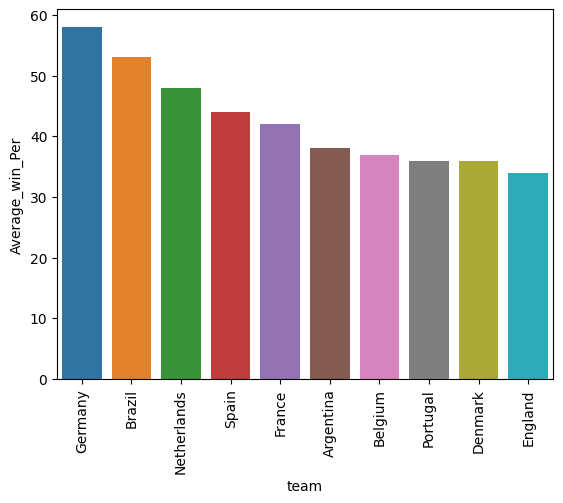

In [19]:
#data viz for average win
sns.barplot(data=rank_top10_Win,x='team',y='Average_win_Per')
plt.xticks(rotation=90);

# Dataset preparation

## Make dataset for preliminary

In [ ]:
#Mapping numeric values for home_team_result to find the correleations
#win = 1
#Draw = 2
#lose = 0
final_df['home_team_result'] = final_df['home_team_result'].map({'win':1, 'Draw':2, 'lose':0})

In [ ]:
final_df.corr()['home_team_result'].sort_values(ascending=False)

In [ ]:
final_df.columns

In [ ]:
final_df =final_df.drop(['date','win_conditions','home_team_previous_points','away_team_points'], axis=1)

In [ ]:
final_df.tail()

In [ ]:
plt.figure(figsize=(10,4),dpi=200)
sns.heatmap(final_df.corr(),annot=True)

In [ ]:
final_df.info()

In [ ]:
#Holdout another DF for pipeline
pipe_DF = final_df
#Create dummies for categorical columns
final_df = pd.get_dummies(final_df)

# Prediction models for preliminary round - W,D,L

In [ ]:
#split X and y and train test split (For League Matches)
X = final_df.drop('home_team_result',axis=1)
y = final_df['home_team_result']
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
#Validtion and test set
X_hold_test, X_test, y_hold_test, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

In [ ]:
#Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_hold_test = scaler.transform(X_hold_test)


In [ ]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
#function to fit different model and vizualize them
def metrics_display(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

In [ ]:
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
metrics_display(DecisionTreeClassifier())

In [ ]:
#Random Forest 
from sklearn.ensemble import RandomForestClassifier
metrics_display(RandomForestClassifier())

In [ ]:
#Ada Boost Classifier
from sklearn.ensemble import AdaBoostClassifier
metrics_display(AdaBoostClassifier())


In [ ]:

#XGB Boost
from xgboost import XGBClassifier
metrics_display(XGBClassifier(use_label_encoder=False))

In [ ]:
X_train.shape


In [ ]:
#simple Neural network
#p.s : can't run it on my machine because of the tensorflow package conflicts with M1, try to run and see the results
import keras
from keras import Sequential
from keras.layers import Dense,Dropout
from keras import Input

model = Sequential()
model.add(Input(shape=(182,)))
model.add(Dense(300,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(200,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train,y_train,epochs=10,validation_split=0.2)

y_pred1 = model.predict(X_test)
y_pred1 = np.argmax(y_pred1,axis=1)
print(classification_report(y_test,y_pred1))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred1)

In [ ]:
#Checking the final score on testing the holdout test in XGB
model = XGBClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_hold_test)
print(classification_report(y_hold_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_hold_test,y_pred);

In [ ]:
#XGB Model is finalised, so creating a pipeline for the prelim
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
column_trans = make_column_transformer(
    (OneHotEncoder(),['home_team', 'away_team']),remainder='passthrough')

pipe_X = pipe_DF.drop('home_team_result',axis=1)
pipe_y = pipe_DF['home_team_result']

from sklearn.pipeline import make_pipeline
pipe_League = make_pipeline(column_trans,StandardScaler(with_mean=False),XGBClassifier(use_label_encoder=False))
pipe_League.fit(pipe_X,pipe_y)


In [ ]:
#Dumping the pipeline model
import joblib
#joblib.dump(pipe_League,"League_Predictions.pkl")

# Prediction for Knockout Stage  - Removing Draw Status

In [ ]:
#removing draw results (draw == 2)
knock_df = pipe_DF[pipe_DF['home_team_result'] != 2]

In [ ]:
pipe_knock_df = knock_df
knock_df = pd.get_dummies(knock_df)
X = knock_df.drop('home_team_result',axis=1)
y = knock_df['home_team_result']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_hold_test, X_test, y_hold_test, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)


In [ ]:
metrics_display(RandomForestClassifier())

In [ ]:
#Random Forest is giving good accuracy, so testing with holdout test and finalising the model
model = RandomForestClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_hold_test)
print(classification_report(y_hold_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_hold_test,y_pred);


In [ ]:
#Building pipeline for knockout round
pipe_X = pipe_knock_df.drop('home_team_result',axis=1)
pipe_y = pipe_knock_df['home_team_result']
column_trans = make_column_transformer(
    (OneHotEncoder(),['home_team', 'away_team']),remainder='passthrough')
pipe_knock = make_pipeline(column_trans,StandardScaler(with_mean=False),RandomForestClassifier())
pipe_knock.fit(pipe_X,pipe_y)


In [ ]:
#joblib.dump(pipe_knock,"KnockOut_Predictions.pkl")

# KNN Classifier


In [ ]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import cross_validate

In [ ]:
model = KNeighborsClassifier()
cross_validate(model, X, y, cv = 5)

In [ ]:
#Checking the score for the preliminary match
metrics_display(KNeighborsClassifier())

In [ ]:
#checking the final score in the KNeighbours Classifiers
model = KNeighborsClassifier(n_neighbors=5)  
model.fit(X_train, y_train)


In [ ]:
y_pred = model.predict(X_hold_test)
print(classification_report(y_hold_test,y_pred))
ConfusionMatrixDisplay.from_predictions(y_hold_test,y_pred);

In [ ]:
pipe_X = pipe_knock_df.drop('home_team_result',axis=1)
pipe_y = pipe_knock_df['home_team_result']
column_trans = make_column_transformer(
    (OneHotEncoder(),['home_team', 'away_team']),remainder='passthrough')
pipe_knock = make_pipeline(column_trans,StandardScaler(with_mean=False),KNeighborsClassifier())
pipe_knock.fit(pipe_X,pipe_y)
